In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from utilities import get_network, transform_df

# Generating the data

Don't run this if `dataset-with-toxicity.csv` has been generated already.

In [6]:
# when we merge dataset and put it in csv, these no longer retain their original types
# so we need the converters + eval to bring their original form back basically
df = pd.read_csv('data/primary-dataset.csv') 
df["hashtags"] = df["hashtags"].apply(str).apply(lambda x: x.split(","))
df["to"] = df["to"].apply(str).apply(lambda x: x.split(","))

In [7]:
df

,screen_name,created_at,hashtags,followers_count,friends_count,text,is_quote,is_retweet,favourites_count,retweet_count,country_code,verified,lang,to
0,RonniSalt,2020-03-29T00:00:29Z,[covid19],27898,3544,Good to see the Prime Minister's buddy out the...,False,False,225775,137,NaN,False,en,[@ScottMorrisonMP]
1,CPHO_Canada,2020-03-29T00:03:14Z,"[publichealth, physicaldistancing, covid19, st...",136733,182,2/4 A note of cautious optimism from British C...,False,False,530,141,NaN,True,en,[@CPHO_Canada]
2,RVAwonk,2020-03-29T00:03:41Z,[covid19],437022,3703,CDC is denying a rumor that the agency is prep...,True,False,90581,168,NaN,False,en,[@CDCgov]
3,byQueenVic,2020-03-29T00:07:37Z,[coronavirus],47206,3800,Prince William and Kate have described the las...,False,False,6222,72,NaN,True,en,[@PHE_uk]
4,ChristinePolon1,2020-03-29T00:07:45Z,"[coronavirus, washhands]",37473,6892,Still no one at my local Walmart sick that wor...,False,False,274262,64,NaN,False,en,[@realDonaldTrump]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23111,CPHO_Canada,2020-04-30T23:49:51Z,"[covid19, physicaldistancing, handwashing]",189620,182,4/5 While we are eager to get out of our house...,False,False,541,54,NaN,True,en,[@CPHO_Canada]
23112,holmescnn,2020-04-30T23:50:12Z,"[trump, coronavirus, china]",22961,2451,#Trump contradicts US intel community by claim...,False,False,3022,167,NaN,True,en,"[@kylieatwood, @ZcohenCNN, @MarquardtA, @Acosta]"
23113,OnTheRedCarpet,2020-04-30T23:53:12Z,"[covid19, queen, adamlambert]",58594,1178,YOU are the Champions🎶 @QueenWillRock and @ada...,False,False,13496,56,NaN,True,en,"[@adamlambert, @QueenWillRock, @WHO]"
23114,SenatorDurbin,2020-04-30T23:54:13Z,[covid19],658190,2366,.@SenateDems are ready to go back to work next...,False,False,576,83,NaN,True,en,[@SenateDems]


# Toxicity analysis

## Generating toxicity 

** Only run if toxicity dataset hasn't been generated before. **

In [11]:
from googleapiclient import discovery
import json
import time

API_KEY = 'PUT_API_KEY_HERE' # see https://developers.perspectiveapi.com/s/docs-get-started to get API key

client = discovery.build(
  "commentanalyzer",
  "v4",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
)

# Given a text body, makes request to the Perspective API and returns
# toxicity score
def getToxicity(text):
    analyze_request = {
        'comment': { 'text': text },
        'requestedAttributes': {'TOXICITY': {}},
        'languages': ["en"]
    }

    response = client.comments().analyze(body=analyze_request).execute()
    # print(json.dumps(response, indent=2))

    return response["attributeScores"]["TOXICITY"]["summaryScore"]["value"]

In [7]:
# Only run if toxicity has been previously computed 
# THIS TAKES 40+ MINUTES!

# Iterates through each tweet in the DataFrame, gets its toxicity score,
# and stores it in the `toxicity` column
# We only have 10QPS limit for the API, so this makes at most 10 requests
# per second, and sleeps whenever necessary.

# toxicityDf = df
# toxicityDf["toxicity"] = 0
# i = 0
# j = 0
# start = time.time()
# for index, row in toxicityDf.iterrows():
#     toxicityDf.loc[index, 'toxicity'] = getToxicity(row["text"])
    
#     i += 1
#     end = time.time()
#     if(end - start < 1 and i == 9):
#         time.sleep(1.0-(end - start))
#         start = time.time()
#         i = 0

#     j+=1
#     print(f"processed {j}")

# toxicityDf.to_csv("data/dataset-with-toxicity.csv", index=False)

In [9]:
toxicityDf = pd.read_csv('data/dataset-with-toxicity.csv') 
toxicityDf["hashtags"] = toxicityDf["hashtags"].apply(str).apply(lambda x: x.split(","))
toxicityDf["to"] = toxicityDf["to"].apply(str).apply(lambda x: x.split(","))

G = get_network(toxicityDf)

G.number_of_nodes()

18550

In [10]:
remove = [node for node, degree in dict(G.degree()).items() if degree < 5]
G.remove_nodes_from(remove)
G.number_of_nodes()

2407

In [11]:
for node in G.nodes():
    in_data = G.in_edges(node, data=True)
    out_data = G.out_edges(node, data=True)

    incoming_toxicity = sum(i[2]["toxicity"] for i in in_data)
    outgoing_toxicity = sum(i[2]["toxicity"] for i in out_data)

    in_degree = len(in_data) if len(in_data) != 0 else 1
    out_degree = len(out_data) if len(out_data) != 0 else 1

    avg_in_tox = incoming_toxicity
    avg_out_tox = outgoing_toxicity

    G.nodes[node]['avg_in_toxicity'] = avg_in_tox / 100
    G.nodes[node]['avg_out_toxicity'] = avg_out_tox / 100
    G.nodes[node]['total_avg_toxicity'] = (avg_in_tox+avg_out_tox)


In [12]:
# Average toxicities of the politicans 

G.nodes["@realDonaldTrump"], G.nodes["@BarackObama"], G.nodes["@narendramodi"]

({'avg_in_toxicity': 0.6149383209699996,
  'avg_out_toxicity': 0.0,
  'total_avg_toxicity': 61.49383209699996},
 {'avg_in_toxicity': 0.05226664864999999,
  'avg_out_toxicity': 0.0,
  'total_avg_toxicity': 5.226664864999999},
 {'avg_in_toxicity': 0.16042747779000002,
  'avg_out_toxicity': 0.0,
  'total_avg_toxicity': 16.042747779000003})

### Correlation between no. of tweets and toxicity

Groups users by the number of tweets they have in the dataset and averages the toxicity. 

In [13]:
users = dict(toxicityDf["screen_name"].value_counts())
counts = {}

for user in users:
    count = users[user]
    if count in counts:
        t = counts[count]
        t.append(user)

        counts[count] = t
    else:
        counts[count] = [user]

toxicityByCount = {}

for count in counts:
    count_users = counts[count]

    toxicities = toxicityDf[toxicityDf['screen_name'].isin(count_users)]["toxicity"]

    toxicityByCount[count] = toxicities.mean()


As seen below, there's no correlation.

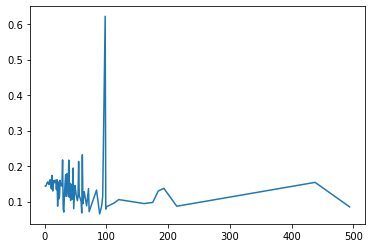

In [14]:
plt.plot(list(toxicityByCount.keys()), list(toxicityByCount.values()))

In [15]:
# Toxicity over time for a given user
# Given a username, generates the incoming toxicity plot over time for that user 

def getIncomingToxicityGivenUser(user):
    mask = toxicityDf["to"].apply(lambda x: user in x)
    modiDf = toxicityDf[mask]

    modiDf['created_at'] = pd.to_datetime(modiDf['created_at'])

    modiDf = modiDf.groupby([modiDf['created_at'].dt.date]).mean()
    modiDf = modiDf.reset_index()

    modiDf["created_at"] = modiDf["created_at"].astype(str)

    dates = list(modiDf["created_at"])
    toxs = list(modiDf["toxicity"])

    plt.plot(dates, toxs, label=f"toxicity for {user} over time")
    plt.xticks(rotation=90)
    plt.xlabel('date',fontsize=14)
    plt.ylabel('toxicity',fontsize=14)
    plt.legend()

### Toxicity for @narendramodi

We looked at @narendramodi's toxicity in the report and found his network to be more positive than other politicial leaders. 

As a result, here we look at how the toxicity in his network evolves over the timeframe of the dataset.

<ipython-input-15-3bc790f7a3ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modiDf['created_at'] = pd.to_datetime(modiDf['created_at'])


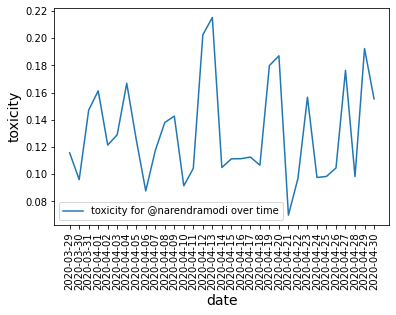

In [16]:
getIncomingToxicityGivenUser("@narendramodi")